# AC290 Extreme Computing: Project-based High Performance Distributed and Parallel Systems

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

## Simulated Annealing

Simulated annealing is one of the most popular stochastic techniques for global optimization problems.  The technique is inspired by annealing in metallurgy, a technique in heating and cooling of material to increase its size and purity.     

Simulated annealing was independently proposed by Kirpatrick, Gelatt, and Vecchi in 1983 and by Cerny in 1985.  The method was derived from the Metropolis-Hastings algorithm, Markov Chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution.    

Borrowing concepts from thermodynamics, simulated annealing utilizes the metaphorical notion of temperature to determine the acceptance and rejection of a state.  The algorithm denotes energy of a state $i$, the current state, to be $E_i$ and subsequent state $j$ as $E_j$.  Change in energy due to the change in state is denoted as $\Delta E = E_j - E_i$.  The new state $j$ is "accepted" with the probability of 

$$P(X=j) = exp(\frac{-\Delta E }{T})$$

Given a function $f$ to optimize - finding the global maxima or the global minima - the algorithm defines the elements of the domain of the function as states and the range of the function as energy.

The algorithm begins with sufficiently high temperature $T$, which increases the acceptance probability $P(X)$, and in order for the algorithm to explore the search space.  As acceptance number increases, the temperature is steadily cooled, which consequently decreases the acceptance rate of new states.  When the temperatrue is cooled to sufficiently low level, the system reaches thermal equilibrium or in MCMC, a stationary state. 

### Algorithm
1. Initialize $x_0$, $T$, $L$, where $L$ is the step size 
2. for $i$ through $i_{max}$:
    1. Propose a new $x^* \leftarrow neighbor(x_{i}, L)$
    2. Draw $u \sim Uniform(0,1)$
    3. if $u < P(X=x^*)$, 
        1. $x_i = x^*$
    5. Update $T$ and $L$
3. $x_{opt} = x_i$
4. Return $x_{opt}$

### Selecting Parameters

1. Temperature Schedule.  Popular choices are:
    1. Linear: temperature decreases as $T_{i+1} = \alpha T_{i}$, where $0.8 \leq \alpha \leq 0.9$
    2. Exponential: temperature decreases as $\alpha^{i}$, where $0.8 \leq \alpha \leq 0.9$
    3. Logarithmic: temperature decreases as $\frac{1}{log(i)}$
2. $L$, step size.  Consider the following questions:
    1. How large (small) should you set $L$?
    2. Should you dynamically adjust $L$ - popular choice is $L=sqrt(T)$
3. Annealing interval - number of proposals to accept before cooling.
    1. Typically, annealing interval is 100
4. Stopping criterion. Consider when appropriate:
    1. Max iteration $i_{max}$
    2. Objective limit.  Stop the algorithm if the objective has been reached.
    3. Functional tolerance.  Stop the algorithm if the average change in the objective function after $m$ iteration is below a specified tolerance level


Finding the optimal parameter is an art as much as it is science.  Sometimes, you will run your simulated annealing algorithm for several iterations until you arrive at the appropriate parameters.

### 1. Optimization over $\mathbb{R}^n$

#### 1.1. Rastrigin Function

We'll begin by solving for global minima of Rastrigin function in $\mathbb{R}^2$.  The rastrigin function is a popular non-convex function used to test optimization methods.

$$f(x_1, x_2)=20+x^2_1+x^2_2−10[cos(2πx_1)+cos(2πx_2)]$$

In [3]:
f = lambda x1,x2 : 20 + x1*x1 + x2*x2 - 10 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))

In [4]:
x1 = np.linspace(-5.12,5.12,50)
x2 = np.linspace(-5.12,5.12,50)
X1,X2 = np.meshgrid(x1,x2)

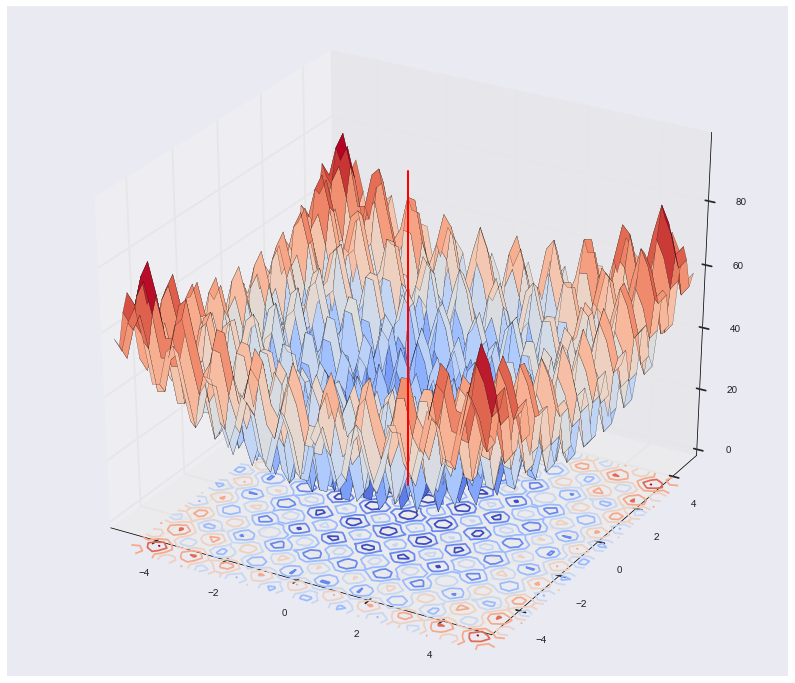

In [5]:
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, f(X1,X2), rstride=1, cstride=2, linewidth=0.2, cmap=cm.coolwarm)
ax.contour(X1, X2, f(X1,X2), zdir='z', offset=-10, cmap=cm.coolwarm)
ax.plot(np.zeros(100),np.zeros(100),range(100), c='r', lw=2, zorder=8)
plt.show()

As we can observe from the surface plot of the function above, finding the global minima of the rastrigin function poses computation challenge because the function has large number of local minima.

The global minima of the function is $(0,0)$ where $f(0,0)=0$

In [6]:
f(0,0)

0.0

#### 1.2. Finding Global Minima

In [7]:
def simulated_annealing_rst(function, initial_X, initial_temp, cool, reanneal, iterr):
    
    accepted = 0
    X = initial_X.copy()
    T = initial_temp
    
    history = list()
    # Evaluate E
    prev_E = function(*X)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Stepsize
        L = np.sqrt(T)
        COV = [[L,0],[0,L]]
        # Propose new x1 and x2 - Metropolis Algo.
        X_star = np.random.multivariate_normal(X, COV)
        # Evaluate E
        new_E = function(*X_star)
        delta_E = new_E - prev_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star.copy()
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 1.
            
    return X, history

In [8]:
# Simulated Annealing Parameters
initial_X = np.random.multivariate_normal([4,4], [[1,0],[0,1]]) # Start random
initial_temp = 2.
cool = 0.9
reanneal = 100
iterr = 10000

In [9]:
solution, history = simulated_annealing_rst(f, initial_X, initial_temp, cool, reanneal, iterr)

In [10]:
print "Solution (x1,x2):",solution
print "f(x1,x2):",f(*solution)

Solution (x1,x2): [-0.00055162  0.00630293]
f(x1,x2): 0.00794084134483


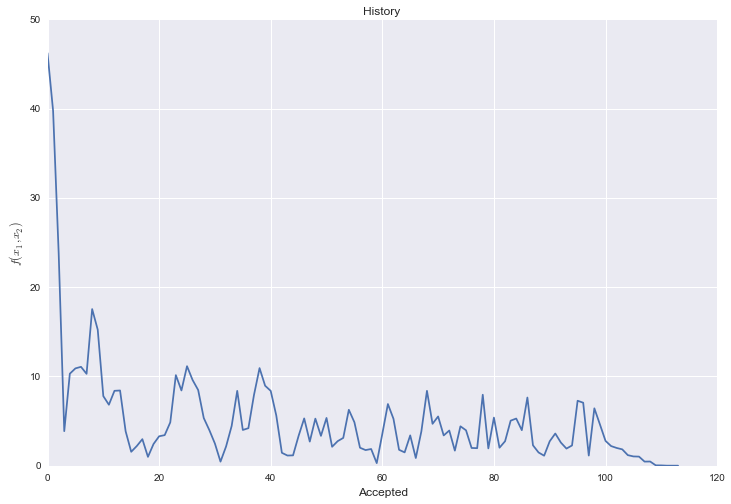

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()

### 2. Traveling Salesman

Simulated Annealing has been shown to be even more effective in problems with discrete search space such as the Traveling Salesman Problem (TSP).  

TSP asks, "Given a list of cities and distances between the cities, what is the shortest possible route that visits each city exactly once and returns to the original city?"  It is an well-known NP-hard problem in combinatorial optimization methods; given $N$ cities, there are $N!$ possible paths.  For large $N$, this becomes a computationally challenging problem. 

Here, we will use simulated annealing to search for the optimal shortest path in $N=25$ cities.  There are $25!$ (Some very large number!) possible paths in our search space.  We will not be able to solve this problem using exhausitive search; instead, we resort to simulated annealing, which will yield approximation of optimal shortest path.

The TSP example below was borrowed from AM207 lecture notes on Simulated Annealing.

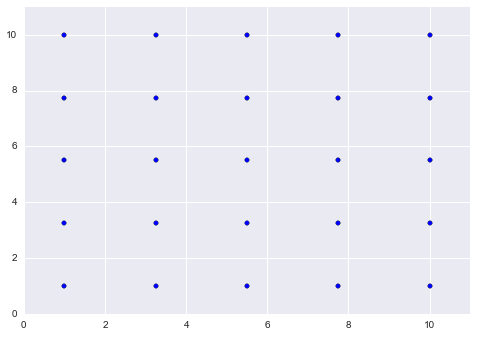

In [12]:
# Generate 25 Cities on 2D Euclidean Plane
x = np.linspace(1,10,5)
y = np.linspace(1,10,5)
tmpx, tmpy =  np.meshgrid(x,y)

cities = np.array([tmpx, tmpy])
cities = np.reshape(cities, (2,-1)).T

plt.scatter(cities[:,0], cities[:,1])
plt.xlim(0,11)
plt.ylim(0,11)
plt.show()

Create a function to visualize a pathway between the cities.  This is to help us visually confirm our algorithm's accuracy.

In [13]:
def plot_path(pcities):
    plt.plot(pcities[1:,0], pcities[1:,1],'o')
    plt.plot(pcities[:,0], pcities[:,1])
    plt.plot(pcities[0,0], pcities[0,1], '^')
    plt.xlim(np.min(pcities[:,0])-1, np.max(pcities[:,0])+1)
    plt.ylim(np.min(pcities[:,1])-1, np.max(pcities[:,1])+1)

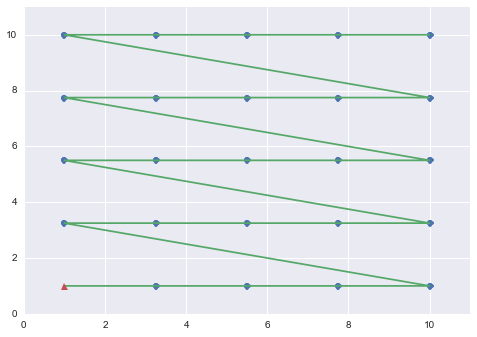

In [14]:
plot_path(cities)

Note that the red triangle indicates starting city.

We create $distance$ function, which will serve as our $E$, energy.  Given a pathway around all cities, $distance$ will return the total distance traveled.  Our goal is to minimize this function.

In [15]:
def distance(citypath):
    distance = 0
    number_of_cities = len(citypath)
    
    # loop over all cities
    for j in xrange(number_of_cities):
        if j == (number_of_cities - 1): # FINAL POINT CONNECTS WITH THE FIRST ONE
            distance += np.linalg.norm(citypath[j,:] - citypath[0,:])
        else:
            distance += np.linalg.norm(citypath[j,:] - citypath[j+1,:])
    return distance

In [16]:
distance(cities)  # Current total distance as it is 

94.835872691916805

In [28]:
cities
cities[1,:] - cities[0,:]

array([ 2.25,  0.  ])

In the rastrigin function, we used Numpy's $multivariate_normal$ function to propose $x_1$ and $x_2$ in $\mathbb{R}^2$.  However, in our problem, we need find a clever method to propose new pathway from an existing pathway.  Thus, we will create a new pathway proposal function, $changepath$, that will perturb $n$ number of pathways given an original pathway.

In [18]:
# Helper Function 
def swapindex(cities):
    indices = range(len(cities))
    # take two random indices to swap
    c1,c2 = np.random.choice(indices, 2, replace=False)
    
    # remember the cities to swap
    tmp1 = cities[c1,:]
    tmp2 = cities[c2,:]
    
    # do the actual swapping
    changedCities = cities.copy()
    changedCities[c1,:] = tmp2
    changedCities[c2,:] = tmp1
    
    return changedCities

def changepath(inputcities, n_swaps):
    cities = inputcities.copy()
    # Make n_swaps number of swaps
    for i in range(n_swaps):
        swappedCities = swapindex(cities)
        cities=swappedCities.copy()

    return cities

#### 2.2. Simulated Annealing

In [19]:
# TODO
def simulated_annealing_rst(function, initial_X, initial_temp, cool, reanneal, iterr):
    
    accepted = 0
    X = initial_X.copy()
    T = initial_temp
    
    history = list()
    # Evaluate E
    prev_E = function(X)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Propose new path.
        X_star = changepath(X, 2)
        # Evaluate E
        new_E = function(X_star)
        delta_E = new_E - prev_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star.copy()
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 1.
            
    return X, history

In [20]:
# Simulated Annealing Parameters
initial_X = cities # Start random
initial_temp = 2.
cool = 0.9
reanneal = 100
iterr = 30000

In [21]:
solution, history = simulated_annealing_rst(distance, initial_X, initial_temp, cool, reanneal, iterr)

In [22]:
print "path:",solution
print "distance:",distance(solution)

path: [[  7.75   5.5 ]
 [  7.75   3.25]
 [ 10.     5.5 ]
 [ 10.     3.25]
 [ 10.     1.  ]
 [  7.75   1.  ]
 [  5.5    1.  ]
 [  3.25   1.  ]
 [  1.     1.  ]
 [  1.     3.25]
 [  1.     5.5 ]
 [  5.5    5.5 ]
 [  5.5    7.75]
 [  7.75   7.75]
 [ 10.     7.75]
 [ 10.    10.  ]
 [  7.75  10.  ]
 [  5.5   10.  ]
 [  3.25  10.  ]
 [  1.    10.  ]
 [  1.     7.75]
 [  3.25   7.75]
 [  3.25   5.5 ]
 [  3.25   3.25]
 [  5.5    3.25]]
distance: 60.3639610307


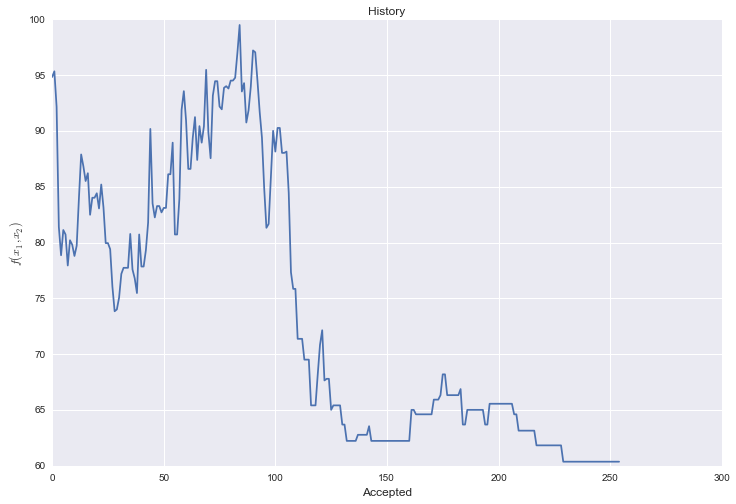

In [23]:
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()